# Computer Vision: a short look at border detection

In this notebook, I talk about what border detection is, how it works, and go over some of the key algorithms used for this purpose.

## Table of Contents

### 1.[Introduction](#introduction)
### 2. [Exploring different border detection algorithms](#exploring-different-border-detection-algorithms)
> #### 2.1 [Gradient-based](#gradient-based-algorithms)
> #### 2.2 [Second derivative-based](#second-derivative-based-algorithms)
> #### 2.3 [Other Methods](#other-methods)
### 3. [Final Thoughts](#final-thoughts)
### 4. [Additional Resources](#additional-resources)

### Base Utils

Some basic functions that will save us lines of code further down the road.

In [1]:
# libraries
import requests
import numpy as np
from PIL import Image
from io import BytesIO
from typing import Union
import matplotlib.pyplot as plt


def show_image(
        image: np.ndarray, 
        title: Union[str, None] = None,
        figsize=(8,6)
) -> None:
    '''Receive a np.ndarray of an image an plot it.'''
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    if isinstance(title, str):
        plt.title(title)
    plt.show()


def show_images_side_by_side(
        images: list,
        titles: list,
        figsize: tuple = (15, 6)
) -> None:
    '''
    Display an arbitrary number of images side-by-side.
    Might look poorly if using more than 5 images.

    Params
    -------
        images: list
            list of np.ndarray objects, representing greyscale
            images.
        titles: list
            list of titles in the order that they should be assigned
            to each image.
        figsize: tuple 
            contains the width and height of the plot.

    '''
    if not len(images) == len(titles):
        print("Error: 'images' and 'titles' have different size.")
        return

    total_images = len(images)
    plt.figure(figsize=figsize)
    for i in range(total_images):
        plt.subplot(1, total_images, i+1)  # (rows, columns, position)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


def download_image(
    url: str
) -> np.ndarray:
    '''Download image from the web and save as np.ndarray.'''
    response = requests.get(url)
    image = Image.open(
        BytesIO(response.content)
    ).convert('RGB')  # RGB format (red-green-blue)
    image = np.array(image)

    return image

---------
### Introduction

Edge or border detection is a technique used to identify the boundaries of one or more objects within an image. This is done by identifying sections of an image where color (or pixel intensity, to be more precise) changes sharply.

Edges are perpendicular to the direction in which the pixel intensity change occurs. For example, let's look at the following image:

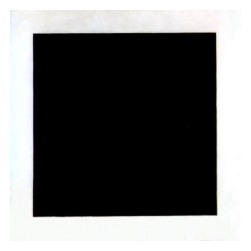

In [2]:
example = download_image(
    "https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg"
)
show_image(example, figsize=(4,3))

We recognize the horizontal upper boundary of the black square because of the color change that occurs in the vertical direction. This is a very oversimplified case, but the same principle applies to different shapes and objects.

Sharper pixel intensity changes (like white to black) define stronger edges, while softer transitions may be weak edges, changes in illumination, a texture change or noise that we want to ignore when outlining the basic objects in the image.

When setting up edge detection, it's important to ensure that the algorithm is capable of recognizing the main edges that outline the different objects in the image, while also ignoring false edges of the sort we've described.

-------------
### Exploring different border detection algorithms

Different authors name different categories for edge detection algorithms, but I want to go over two of them: **gradient-based**, **second derivative-based**.
At the end, I'll also discuss other methods that are more advanced. 

For testing purposes, we'll be using the following image:

Initial shape for image: (500, 612, 3)


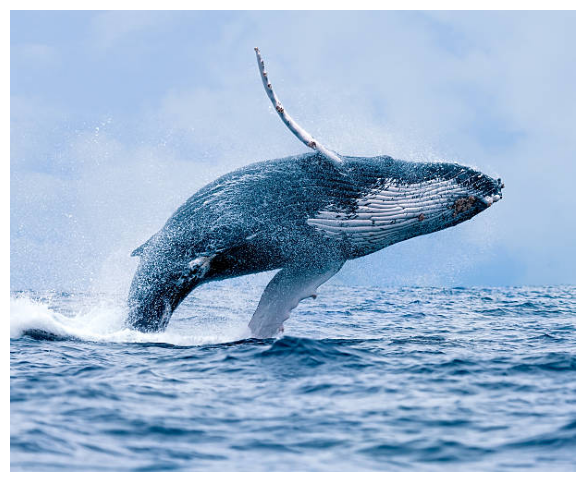

In [3]:
# download image
image = download_image(
    'https://media.istockphoto.com/id/510954971/photo/breaching-humpback-whale.jpg?s=612x612&w=0&k=20&c=rSVBoyBOQYaAbv3TOO9X3SvAoA5WU5Fy9Jd8GT22Os8='
)
print(f"Initial shape for image: {image.shape}")

# display image
show_image(image)

This image of a whale out of water is a good test for edge detection algorithms, as we have the following challenges:

* We have three different entities that should be clearly identified in the image: whale, sea and sky (or the background)

* The whale has complex visual patterns, including parallel grooves along its skin, different tones of dark blue and white, and some brown barnacles near its mouth.

* The delimitation between the sealine and the sky is subtle and doesn't have stark contrasts, which could make it hard to detect. 

* The whale leaves a wake of foam from its burst out of the water, which effectively acts as noise as it blurs the delimitations between whale, sky and sea.

The algorithms I'll be testing on the next section work only on single-channel images (greyscale), not multi-channel (colored). For this reason, before moving on the image must be converted to greyscale.

These algorithms are sensible to noise in the image. Noise refers to areas with very high variation of pixels that obscure the image, like the spray of the water, or more generally things like static in images.

A common method used to reduce noise in images is  **Gaussian Blurring**. This process probably deserves a blog of its own, but it basically reduces detail in an image by setting each pixel's value as a weighted average of the pixels in its neighborhood, with closer pixels having more weight than pixels that are further away.

When working on a discrete space, like an image made of finite pixels, the function needs to be approximated using a convolution matrix, and it has two key parameters:
* `ksize`: The region of pixels to consider when applying the smoothing, with the target pixel at the center of it. It follows that the matrix should be odd in both dimensions, otherwise the target pixel won't be perfectly centered.
* `sigma`: Controls the weight given to nearby pixels based on their distance to the center. The higher this value, the higher the weight attribution to far-away pixels, meaning higher blurring.

New shape for image: (500, 612)


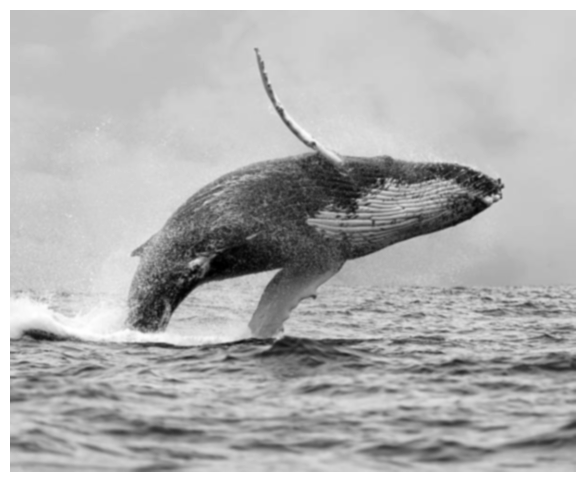

In [ ]:
import cv2


# turn image to gray and convert to np array
gray_image = Image.fromarray(image).convert('L')
gray_image = np.array(gray_image)

# apply gaussian blurring and show
gray_image = cv2.GaussianBlur(
    gray_image,
    ksize=(5, 5),
    sigmaX=1
)
print(f"New shape for image: {gray_image.shape}")
show_image(gray_image)

#### **Gradient-based algorithms**

These are also called first derivative-based algorithms. They detect edges by measuring the rate of change in pixel intensity in different directions (typically vertically and horizontally), using convolution operations on the image.

A convolution is a transformation of an image using a convolution kernel or filter, which is a matrix smaller than the original image that 'slides' along it, performs matrix multiplication in an area of pixels equal to its own size (for example, a 3x3 kernel goes over 3x3 mini-sections of the image) and returns a single value as a result of that operation.

In this application, the convolution should increase the activation values of the pixels that are recognized as edges in a given direction (white), and ignore those that aren't (black). The different convoluted images are then combined (for example, by averaging them) in one single image or matrix, which contains all the edges the algorithm was able to catch from the image.

##### **Sobel**

The Sobel operator is a classic edge detection method that computes the gradient of image intensity in the horizontal and vertical directions, using two simple 3×3 convolution kernels.

It uses the following convolution kernels:

\begin{equation}
G_x = \begin{bmatrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{bmatrix}
\end{equation}

\begin{equation}
G_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
+1 & +2 & +1
\end{bmatrix}
\tag{2}
\end{equation}

If you think about it, these kernels are cleverly set up to augmentate the activation values of areas with transition of colors in the target direction, and reduce the activation of areas that are uniform.

The two kernels are equivalent to each other using the relation:
\begin{equation}
G_y = G_x^T
\tag{3}
\end{equation}

The two partial convoluted images are then aggregated using pythagorean addition:

\begin{equation}
G = \sqrt{G_x^2 + G_y^2}
\tag{4}
\end{equation}

We can implement Sobel and other algorithms with help from the `cv2` library in Python.

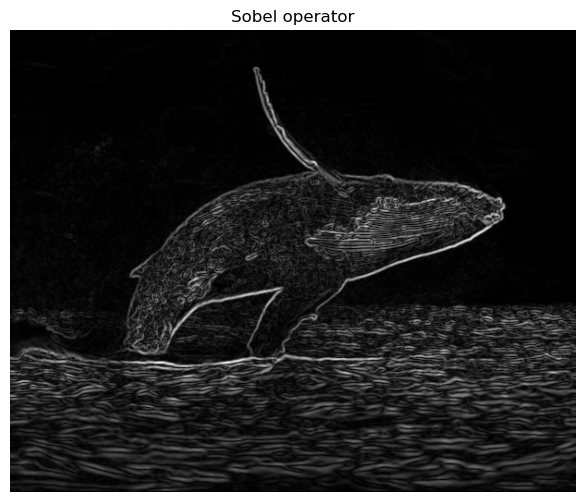

In [ ]:
# compute individual gradients
G_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0)
G_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1)

# aggregate gradients and plot
sobel_image = cv2.magnitude(G_x, G_y)
show_image(sobel_image, title="Sobel operator")

We can see that, after applying the Sobel operator, the whale and the sea are easily recognizable in the new image, and generally the convolution has a very high quality.

However, if we're being picky, there's still room for improvement in reducing the noise from the waves in the sea, as well as around the whale's tail.

##### **Scharr**

Scharr works very similarly to the Sobel operator, except it uses different, more accentuated values for its convolution filters.

Its convolution kernels are:

\begin{equation}
G_x = \begin{bmatrix}
3 & 0 & -3 \\
10 & 0 & -10 \\
3 & 0 & -3
\end{bmatrix}
\tag{5}
\end{equation}

\begin{equation}
G_y = G_x^T
\tag{6}
\end{equation}

Given that it uses higher values in the filters, it gives higher preference to centrally-placed edges in either direction, and should result in a clearer, cleaner distinction between edges and non-edges in the image.

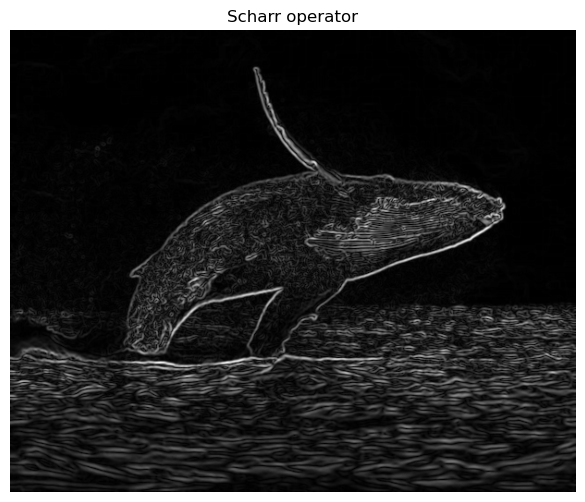

In [ ]:
# compute individual gradients
G_x = cv2.Scharr(gray_image, cv2.CV_64F, 1, 0)
G_y = cv2.Scharr(gray_image, cv2.CV_64F, 0, 1)

# aggregate gradients and plot
scharr_image = cv2.magnitude(G_x, G_y)
show_image(scharr_image, title="Scharr operator")

To the human eye (or my human eye, to be more precise), this convolution looks pretty much the same as the one obtained using `Sobel`, without notable improvements in the limitations mentioned previously.

This doesn't mean `Scharr` will always be the same as `Sobel`, this depends on the image and this one doesn't seem to work to highlight their differences.

##### **Canny**

Canny extends traditional gradient-based operators by adding additional steps to improve border detection and differentiation.

It may use different convolution kernels, but it typically uses Sobel to compute the initial gradients. After this, the new transformations are:

* **Non-maximum suppression**: This part helps produce thinner edges by suppressing any non-maximum values in the direction of the gradient. In other words, it 'cleans' edges by removing weaker edges close to it.

* **Double thresholding and edge tracking by hysteresis**: Edges are classified using two thresholds, a high and a low one. Edges with pixel activation above the high threshold are considered strong, and their path is kept until they meet the second threshold, which is the minimum value for a weak edge. Any pixel activation below the low threshold is suppressed. 
In this step, only strong edges are kept, or weak edges above the minimum threshold that are connected to a strong edge.

The high and low threshold act as hyperparameters which can be tuned to get a better final image from the algorithm. 

Let's try putting these parameters to the test:

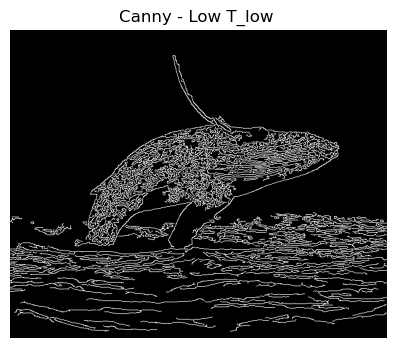

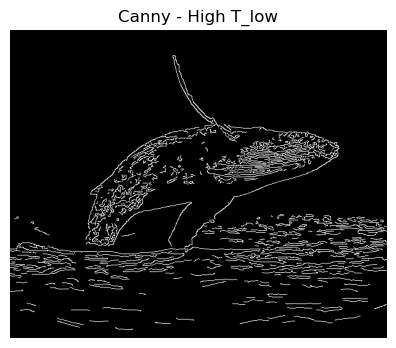

In [8]:
# -----------------------------------
# Move T_low

# low value
canny_image_1 = cv2.Canny(
    image=gray_image, 
    threshold1=10, 
    threshold2=200
)
show_image(canny_image_1, title="Canny - Low T_low ", figsize=(6, 4))

# high value
canny_image_2 = cv2.Canny(
    image=gray_image, 
    threshold1=120, 
    threshold2=200
)
show_image(canny_image_2, title="Canny - High T_low", figsize=(6, 4))

A higher value for `T_low` means that more weak edges are cut off from the image, while a low value means the opposite. This can be seen in the difference between the first and second attempts: many of the waves on the sea are weak edges, and by raising the threshold many of them are eliminated from the image. Some noise is also removed from inside the whale's body.

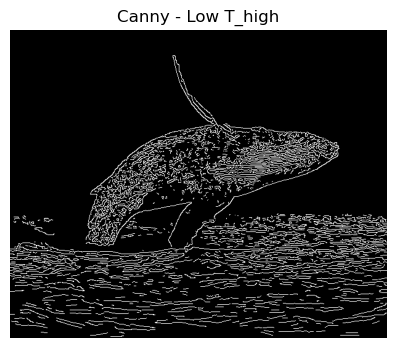

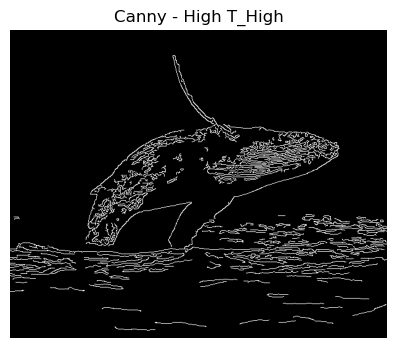

In [9]:
# -----------------------------------
# Move T_high

# low value
canny_image_3 = cv2.Canny(
    image=gray_image, 
    threshold1=100, 
    threshold2=120
)
show_image(canny_image_3, title="Canny - Low T_high", figsize=(6, 4))

# high value
canny_image_4 = cv2.Canny(
    image=gray_image, 
    threshold1=100, 
    threshold2=230
)
show_image(canny_image_4, title="Canny - High T_High", figsize=(6, 4))

Raising the `T_high` parameter creates very similar visual effects to `T_low`, as higher values effectively 'clean up' the image by eliminating weaker edges, albeit by a different mechanism. 

Of all these options, the best result is probably the one from the fourth attempt.

Let's compare the different gradient-based methods side-by-side:

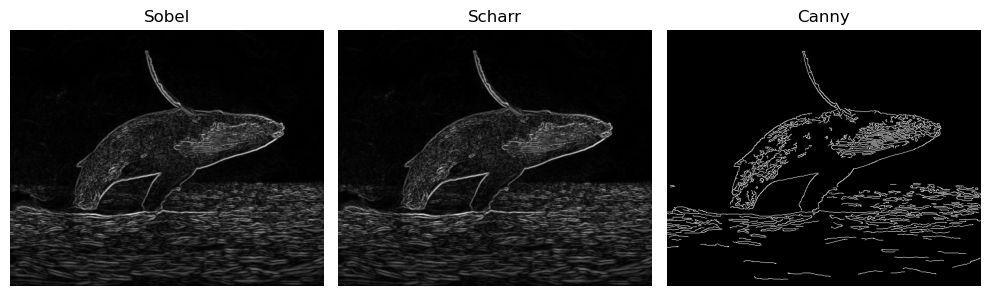

In [10]:
show_images_side_by_side(
    [sobel_image, scharr_image, canny_image_4],
    ["Sobel", "Scharr", "Canny"],
    figsize=(10, 12)
)

The results from the `Sobel` and `Scharr` operators are very similar, which indicates that modifying the convolution filters alone is not enough to create significant changes in the test image.

On the other hand, `Canny` presents a sharp contrast to the previous two methods, by marking everything as either black (not an edge) or white (edge). Even though it's a more robust and complete method, in this case it doesn't really create superior edge detection to the simple operators, at least in what concerns the human eye (it could be preferrable to a Machine Learning model, for example).

* `Canny` actually has more noise than the other two inside the whale, towards the part of the tail, which indicates that the current level of blurring is insufficient to have a good result from this method. It also fails to properly mark the sealine behind the whale, which is at least somewhat visible in the first two methods.

* The different shades of edges present in the first two images can be helpful to better identify the image. Inside the whale, the shades at the right, which are brighter, help identify its throat grooves, which are below the mouth, conveying useful information about its orientation (sideways), which isn't as evident by looking at the image on the right.

#### **Second derivative-based algorithms**

As the name suggests, these methods aims to detect borders using the second derivative of the image, which is a step beyond first-order methods. 

That is, not the rate of change in pixel intensity, but the rate of change in the pixel gradient (the rate of change of the rate of change).

##### **Laplacian**

Mathematically, the Laplacian of an image in a continuous two-dimensional space can be expressed as:

\begin{equation}
\nabla^2 f(x, y) = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}
\tag{7}
\end{equation}

In an actual image, which is finite and takes on discrete values (pixels), the equation must be approximated to resemble the actual transformation using **finite difference approximation**.

Different matrices are used to represent this approximation, but one of the most common is the following:

\begin{equation}
G = \begin{bmatrix}
0 & -1 & 0 \\
-1 & 4 & -1 \\
0 & -1 & 0
\end{bmatrix}
\tag{8}
\end{equation}

This matrix is symmetric, so it meets that:

\begin{equation}
G^T = G
\tag{9}
\end{equation}

This edge detection algorithm, in contrast to a first derivative-based method, doesn't work by identifying high values in the value of the function, but **zero crossings**, which are areas in which the function goes from positive to negative or viceversa very quickly. 

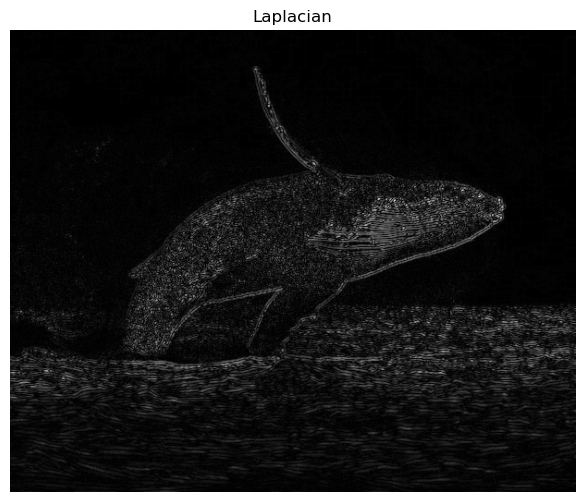

In [32]:
# calculate the laplacian, then convert to absolute scale and show
laplacian_image = cv2.Laplacian(gray_image, ddepth=cv2.CV_64F)
laplacian_image = cv2.convertScaleAbs(laplacian_image)

show_image(laplacian_image, "Laplacian", (8, 6))

The Laplacian, unlike first derivative methods, identifies the location of an edge, but not its direction or magnitude. 

We can see this on the image, as it looks similar to `Sobel` and `Scharr`, but has a somewhat smoother, drop-like finish on the edges. Noise handling appears to be improved in the sea and in the whale's tail, compared to the previous methods.

##### **Difference-of-Gaussians (DoG)**

This method works by generating two different Gaussian blurred versions of an image, one of them slightly blurred and the other heavily blurred, and then subtracting them. The result should contain the relevant edges in the image.

* Why does this work?

By blurring, the finer details of an image, which may have high frequency (changes in pixel intensity), are lost and the area becomes a more homogeneous signal with lower variations. Edges, for example, where high signal variation occurs, are smoothed out when blurring.

Subtracting an image from another of equal shape creates values close to 0 where the pixel activations are very similar, but of higher absolute value where they are different, which precisely helps identify edges. In a less-blurred image, they will be more visible than in a highly-blurred one, whereas homogeneous space, like a blue sky, will look the same blurred or not blurred and will be ignored with the method.

The level of blurring in the images can be controlled using the `sigma` parameter presented above, and this value for the two images effectively acts as a hyperparameter that determines the output of the final image.

* Why is this a second-order method?

Technically, when applying the Laplacian with previous Gaussian signal smoothing, the operation becomes the **Laplacian-of-Gaussian**. Subtracting two Gaussians mathematically approximates this second-order operation very closely, which qualifies it as second order. 

We now introduce a function that will simplify testing out this method for different values of `sigma`.

In [ ]:
def apply_image_dog(
        input_image: np.ndarray,
        sigma_1: float,
        sigma_2: float,
        show_intermediate_images: float = True
) -> np.ndarray:
    '''
    Receives an image and calculates the
    Difference-of-Gaussians edge detection method to it.
    
    The kernel of the smoothing is kept constant, at least for this
    limited scope of application.

    Params
    -------
        image: np.ndarray
            The original image
        sigma_1, sigma_2
            values for the standard deviation when applying
            the GaussianBlur smoothing. The image with the
            higher sigma is subtracted from the other one
        show_intermediate_images
            If True, the partial results for the blurring are
            displayed for reference.

    Returns
    --------
        dog_image: np.ndarray
            Result of subtracting the highly-blurred image from the
            low blur image.
    '''
    # convert image to greyscale if necessary
    if len(input_image.shape) > 2 and input_image.shape[2] > 1:
        input_image = Image.fromarray(input_image).convert('L')
        input_image = np.array(input_image)
    
    # get high blur and low blur image
    if sigma_1 > sigma_2:
        high_sigma = sigma_1
        low_sigma = sigma_2
    else:
        high_sigma = sigma_2
        low_sigma = sigma_1

    high_blur = cv2.GaussianBlur(
        input_image,
        ksize=(5, 5),
        sigmaX=high_sigma
    )
    low_blur = cv2.GaussianBlur(
        input_image,
        ksize=(5, 5),
        sigmaX=low_sigma
    )

    # show images if specified
    if show_intermediate_images:
        show_images_side_by_side(
            [low_blur, high_blur],
            [f'Low Blur: sigma = {low_sigma}', f'High Blur: sigma = {high_sigma}'],
            (10, 10)
        )

    # apply DoG
    dog_image = low_blur - high_blur
    return dog_image

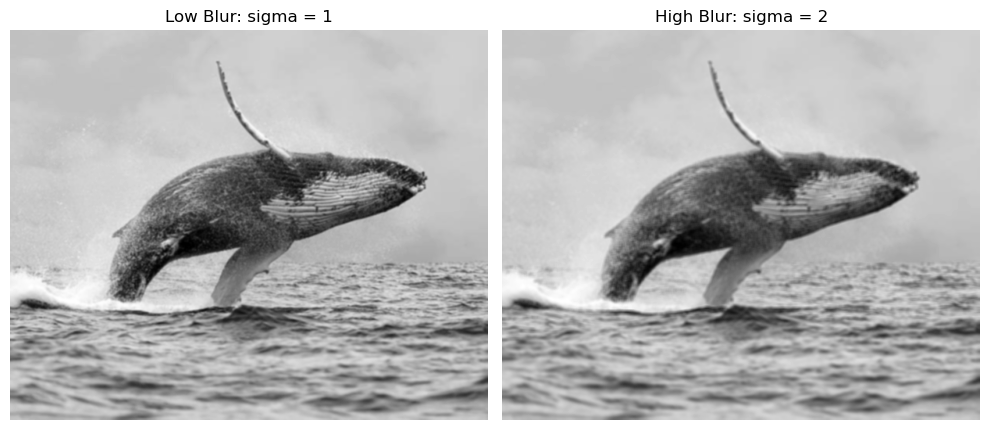

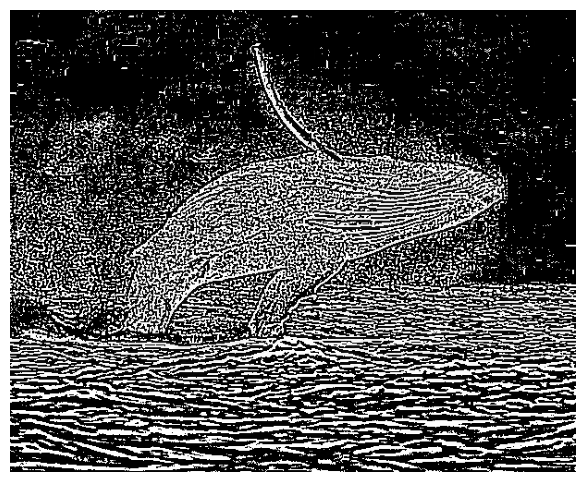

In [21]:
# first test
dog_image_1 = apply_image_dog(image, 1, 2)
show_image(dog_image_1, (6, 4))

At low values of `sigma`, the two blurred images are barely distinguishable from the other by the human eye, and the output result has a lot of noise, resembling a bad photocopy. 

Let's try with higher differences between the two hyperparameters:

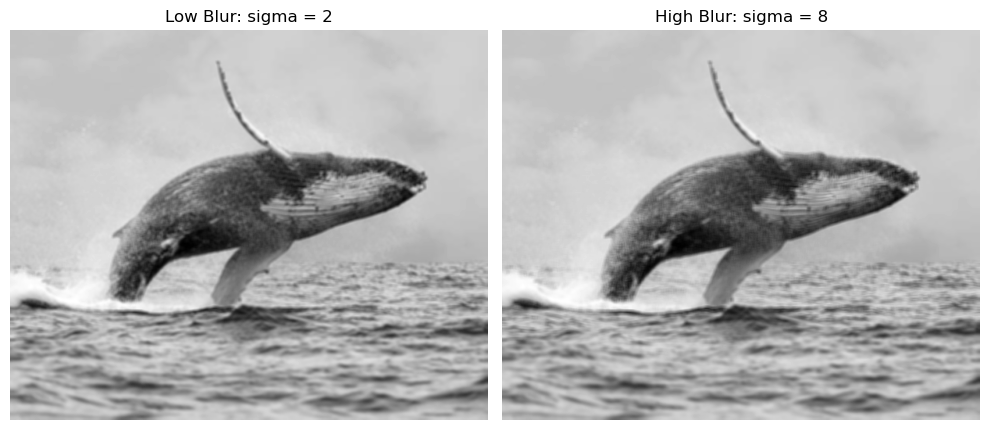

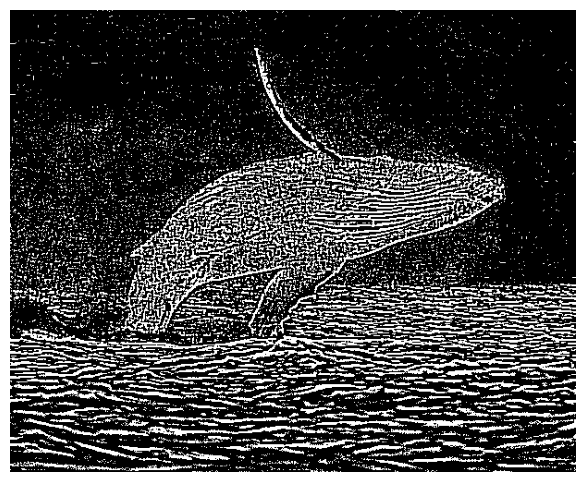

In [27]:
# second test
dog_image_2 = apply_image_dog(image, 2, 8)
show_image(dog_image_2, (6, 4))

This result is much better, even tough there's still high noise in the image. This can be fixed by increasing the blurring from the `low_blur` image, as it will remove the contrast that gets highlighted when subtracting the `high_blur` image. 

Let's try again:

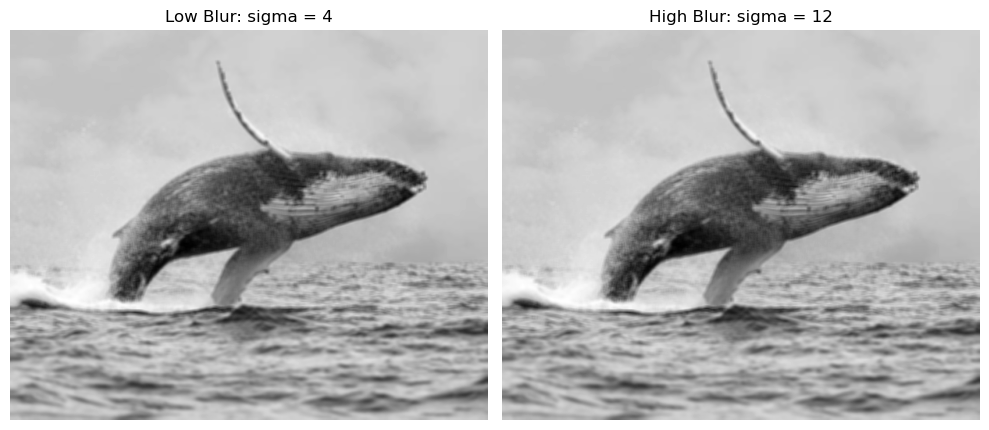

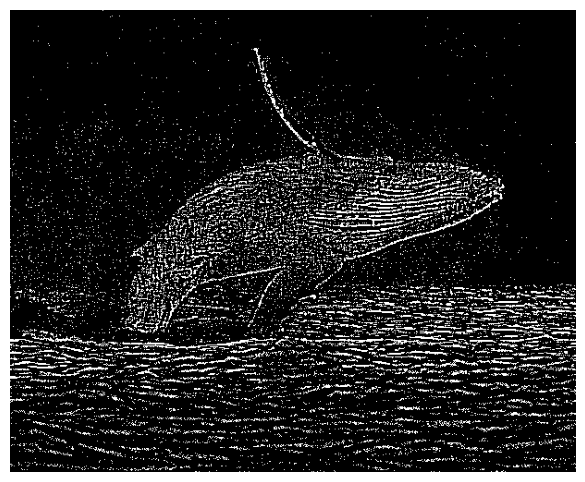

In [28]:
# third test
dog_image_3 = apply_image_dog(image, 4, 12)
show_image(dog_image_3, (6, 4))

This attempt is much better, but it still doesn't manage to completely eliminate the noise from the water spray around the whale. The image can possibly be further enhanced by tweaking the kernel size and other values, but for the current scope this is ok.

With the current function definition, this is very close to the best result that can be obtained with the `DoG` method. If the `sigma` values keep increasing, the blurring in the low-blurred image will be so high that the two images will become increasingly similar to each other, and the end result will be a fully black image.

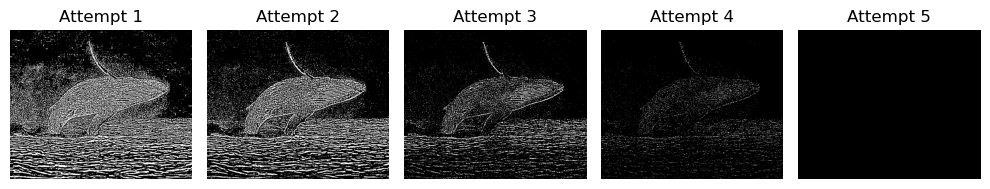

In [30]:
dog_image_4 = apply_image_dog(image, 7, 14, False)
dog_image_5 = apply_image_dog(image, 9, 18, False)

show_images_side_by_side(
    [dog_image_1, dog_image_2, dog_image_3, dog_image_4, dog_image_5],
    ["Attempt 1", "Attempt 2", "Attempt 3", "Attempt 4", "Attempt 5"],
    (10, 12)
)

Starting out with a very low `sigma_low` value generates an image very high in noise, and as both values are increased the noise is removed, then the weak edges, and finally the strong edges until eventually both blurred images are nearly identical and no highlighting occurs from subtracting both images. 

The best compromise was probably the third attempt, as previously shown.

We can now compare the two methods used in this section:

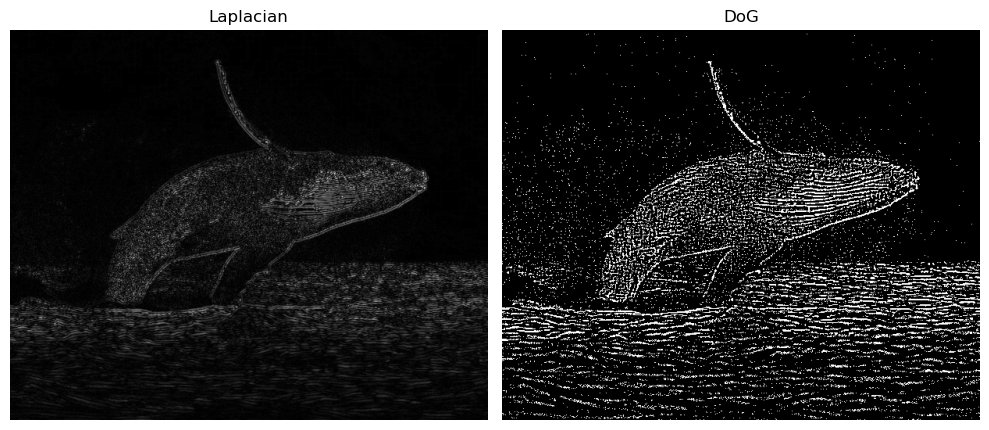

In [33]:
show_images_side_by_side(
    [laplacian_image, dog_image_3],
    ["Laplacian", "DoG"],
    (10, 12)
)

The **Laplacian** method stands out for its smoothness and softness of color, as it picks up none of the noise from the water spray and has a nice drop-like formation of edges.

On the other hand, the **DoG** method does a decent job too, as the whale and its key traits(like the throat grooves) are easily identifiable there as well. However, it does generate a much more blunt final image than the **Laplacian**, with higher noise and a cheap photocopy-like vibe to it.

#### **Other Methods**

The methods seen previously are the 'classical' methods. They are some of the earliest to be used in computer vision, and also the most intuitive. In this section I want to briefly discuss some more modern and powerful border detection methods.

##### **Structured Forests**

This method was originally published in an academic paper published in 2014 you can find [here](https://arxiv.org/abs/1406.5549). The original implementation is somewhat dense to read and understand, and I won't be implementing it in this notebook (it doesn't have a native python package to my knowledge) but I will outline the basics here: 

* It's a machine learning-based method that actually trains a random forest model to identify edges in an image by patches (sub-regions)

* It's a supervised problem, which means it needs a training dataset to teach the model what edges look like

* The output of the model is not a traditional binary output, but a masked version of the image highlighting the edges from the non-edges. This makes the implemantation especially interesting and challenging to apply

* It´s called **structured forests** because it solves a structured learning problem (spatial data) using random forests. Each tree in the forest predicts a particular edge map for the image (one patch at a time), and the result edge mapping is the averaging of those trees' results.

* At the time, it was a state-of-the-art implementation, yielding fast and accurate results for edge detection.

##### **Phase Stretch Transform**

In researching material for this notebook, I came across this method and immediately found it fascinating.

It's inspired on physics, specifically the behavior of light when it travels through a material with diffraction, which distorts it. 

In broad strokes, involves transforming the image to a frequency using a **Fourier Transform**, it goes through a non-linear transformation, and then transforming it back to an image which contains higher contrasts in edges.

Feel free to check it out is you're as intrigued as I am.

-------------
### Final Thoughts

In this notebook, we went through the core principles of some foundational edge detection techniques, and compared them against each other for the test image of a whale coming out of the water. 

Although very limited in scope, I hope it revealed some key insights of how each of the techniques work, its strengths and limitations.

This is all for now, thank you for your time!

------------
### Additional Resources

Here are some resources I found of help to research this mini-project:

#### Learning the Basics
* [Edge Detection (Wikipedia)](https://en.wikipedia.org/wiki/Edge_detection)
* [Edge Detection - An Introduction (Roboflow)](https://blog.roboflow.com/edge-detection/)
* [Comprehensive Guide to Edge Detection Algorithms (GeeksforGeeks)](https://www.geeksforgeeks.org/comprehensive-guide-to-edge-detection-algorithms/)

#### Second-order methods
* [Open CV - Laplacian](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html)
* [Edge Detection Using Laplacian - Youtube](https://www.youtube.com/watch?v=uNP6ZwQ3r6A)
* [Difference of Gaussians - Blog](https://theailearner.com/2019/05/13/difference-of-gaussians-dog/)

#### Other Methods
* [Structured Forests Tutorial](https://docs.opencv.org/4.x/d0/da5/tutorial_ximgproc_prediction.html)
* [Phase Stretch Transform (Wikipedia)](https://en.wikipedia.org/wiki/Phase_stretch_transform)
* [PST Implementation in Python](https://github.com/ChihChengYang/pst)
